# Imports

In [159]:
import json
import random
import torch
import torchvision.transforms as transforms
import numpy as np
from torch import nn
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import requests

import sys
sys.path.append('../Datasets PreProcessing/Real life data')
from preprocessing_utils import *



Define the DEVICE

In [160]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: cpu


# Model Loading

In [161]:
class GradientReversal(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, lamb):
        ctx.lamb = lamb # Save the lambda DA hyperparameter to use during the backward pass
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lamb
        return output, None

class Discriminator(nn.Module):

    def __init__(self, input_size=4608, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, h, lamb):
        h = GradientReversal.apply(h, lamb)
        y = self.layer(h)
        return y
    
class Classifier(nn.Module):

    def __init__(self, input_size=4608, num_classes=13):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, h):
        c = self.layer(h)
        return c
    
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        # Import the VGG16 model
        self.conv = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features

        # Freeze all the weights in modules 0 up-to and including 25
        for param in self.conv[:25].parameters():
            param.requires_grad = False

        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return x

In [162]:
DANN_path = "../Models/DANN/"

# Instantiate the classifier model object for the dann model
DANN_C = Classifier().to(DEVICE)
# Load the state dictionary from the checkpoint file
state_dict = torch.load(DANN_path+"best_model_C.ckpt", map_location=torch.device(DEVICE))
# Load the state dictionary into the model
DANN_C.load_state_dict(state_dict)
# Put the model into evaluation mode
DANN_C.eval()

# Instantiate the feature extractor model object for the dann model
DANN_F = FeatureExtractor().to(DEVICE)
# Load the state dictionary from the checkpoint file
state_dict = torch.load(DANN_path+"best_model_F.ckpt", map_location=torch.device(DEVICE))
# Load the state dictionary into the model
DANN_F.load_state_dict(state_dict)
# Put the model into evaluation mode
DANN_F.eval()

FeatureExtractor(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

# Pipeline function

We first define a function that can translate an array of the predictions of our models to FEN-Notation. The position array passed is a 2D numpy array of the form:




In [163]:
def get_fen_notation(predictions):
    piece_symbols = {
        0: ".",   # Empty square
        1: "P",   # White pawn
        2: "N",   # White knight
        3: "B",   # White bishop
        4: "R",   # White rook
        5: "Q",   # White queen
        6: "K",   # White king
        7: "p",   # Black pawn
        8: "n",   # Black knight
        9: "b",   # Black bishop
        10: "r",  # Black rook
        11: "q",  # Black queen
        12: "k"   # Black king
    }

    fen_rows = []

    for row in predictions:
        fen_row = ""
        empty_count = 0

        for square in row:
            if square == 0:
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += piece_symbols[square]

        if empty_count > 0:
            fen_row += str(empty_count)

        fen_rows.append(fen_row)

    fen_notation = "/".join(fen_rows)  # Hyphen separator for each row

    return fen_notation

In [164]:
def get_random_file_name(folder_path):
    file_names = os.listdir(folder_path)
    if file_names:
        random_file_name = random.choice(file_names)
        return random_file_name
    else:
        return None

In [165]:
def plot_result(predicted_fen, true_fen, image, predicted_fen_img):
    _, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image)
    axs[0].set_title(true_fen, color='green', size=12)

    axs[1].imshow(predicted_fen_img)
    axs[1].set_title(predicted_fen.replace('/', '-'), color='green', size=12)

    for ax in axs:
        ax.axis('off')

    # Set quality to for the plot 
    plt.dpi = 1200

    plt.tight_layout()
    plt.show()

Define the Transformer class

In [166]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((100, 100), antialias=True)])

In [167]:
'''
    Function that takes a FEN notation and returns the image of the board
    fen: FEN notation of the board position predicted by the model

    return: PIL image of the board position predicted by the model
'''
def get_fen_img(fen):
    base_url = "https://fen2image.chessvision.ai/"
    url = base_url + fen
    
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        image = Image.open(response.raw)
        return image
    except (requests.exceptions.HTTPError, requests.exceptions.RequestException, IOError) as e:
        print(f"Error retrieving FEN image: {e}")
        return None

In [168]:
def pipeline(model, model2=None, set="Real", image_name=False, plot=True):
    
    if set == "Real":
        directory_path = "../Datasets PreProcessing/Real life data/Original"
    else:
        directory_path = "../Datasets PreProcessing/Data Generation/Data Generated/Images"

    # If no image name was specified, take a random image
    if image_name == False:
        image_name = get_random_file_name(directory_path)

    # Append selected file name to directory path
    image_path = directory_path + "/" + image_name

    # Remove the .JPG extension to get the FEN noation
    fen = image_name.split('.')[0]

    # Use the pre-processing computer vision algorithm to get each individual square image form the board image
    # Extract the squares by warping the image and cropping it
    warped_image = warp_image(image_path)
    # The squares array is ordered from A1 to H8
    squares = crop_individual_squares(warped_image)

    # Store the predictions in an array. This array will follow the same order as squares so A1 will be at index 0 and H8 at index 63
    prediction = np.array([])

    # Loop through each square and predict the piece 
    for square in squares:
        # Transform the image to a tensor
        image = transform(square)
        
        # Forward pass #1
        y_pred_prob = model(image.unsqueeze(0).to(DEVICE))

        # If there is a second model (for DANN we first gothrough the Feature extractor and then the Classifier)
        if model2:
            y_pred_prob = model2(y_pred_prob)

        # Get the predicted class
        y_pred = torch.argmax(y_pred_prob, dim=1)

        # Append the prediction to the array
        prediction = np.append(prediction, y_pred)

    # Reshape the array to a 8x8 matrix
    prediction = prediction.reshape(8, 8)
    # Transpose the matrix to get the correct orientation
    prediction = prediction.transpose()
    # Flip the matrix vertically to get the correct orientation
    prediction = np.flipud(prediction)

    # Get the FEN notation
    prediction = get_fen_notation(prediction)
    
    # Get the image of the FEN notation
    predicted_fen_img = get_fen_img(prediction)

    plot_result(prediction, fen, warped_image, predicted_fen_img)

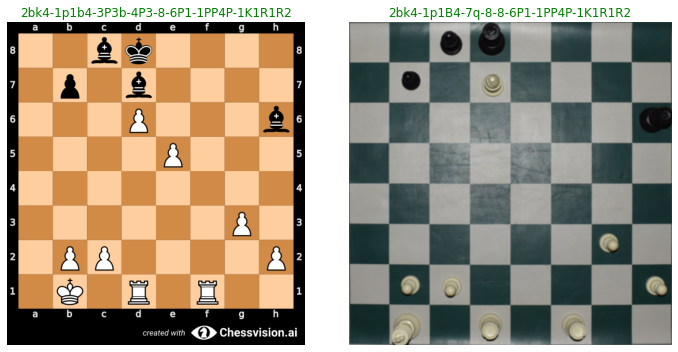

In [169]:
pipeline(DANN_F, DANN_C)